In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

In [42]:
from io_utils import load_matrices_from_dir, load_models
from scipy.sparse.linalg import norm

In [43]:
matrix = "ct20stif"
errorfree_iterations = 364

In [44]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]
mat

<52329x52329 sparse matrix of type '<class 'numpy.float64'>'
	with 2600295 stored elements in Compressed Sparse Column format>

In [45]:
chosen_models = {
    "bcsstk18": "RandomForestRegressor",
    "cbuckle": "KNeighborsRegressor",
    "ct20stif": "XGBRegressor",
    "raefsky4": "RandomForestRegressor",
    "vanbody": "RandomForestRegressor",
}
model_path = f"./models/{matrix}/best_{chosen_models[matrix]}.pkl"
model = load_models([model_path])[0]
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.05561218818274389, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [46]:
pos_2norms = {pos: norm(mat.getrow(pos)) for pos in range(mat.shape[0])}
iter_norm_pairs = np.array([[i, pos_2norms[pos], pos] for pos in range(mat.shape[0])
                              for i in range(errorfree_iterations)])
df = pd.DataFrame(iter_norm_pairs, columns=["i", "2norm", "rowid"])
df["output"] = model.predict(df[["i", "2norm"]].to_numpy())
df.head()

,i,2norm,rowid,output
0,0.0,4.305184e+06,0.0,2.329354
1,1.0,4.305184e+06,0.0,2.329354
2,2.0,4.305184e+06,0.0,4.089900
3,3.0,4.305184e+06,0.0,6.824600
4,4.0,4.305184e+06,0.0,6.824600


In [47]:
df_piv = df.pivot(index=["2norm", "rowid"], columns="i", values="output")

protections = df_piv.to_numpy()
print(protections.shape, mat.shape, 11948 * 432)
df_piv.head()

(52329, 364) (52329, 52329) 5161536


,i,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,354.0,355.0,356.0,357.0,358.0,359.0,360.0,361.0,362.0,363.0
2norm,rowid,,,,,,,,,,,,,,,,,,,,,
1473.855423,27832.0,0.352926,0.352926,0.648519,2.316674,2.316674,0.10162,0.622984,0.563497,1.507696,1.507696,...,0.923043,0.932125,0.932125,0.966129,0.966129,0.989485,0.989485,0.873178,0.877503,0.877503
3762.092180,16273.0,0.352926,0.352926,0.648519,2.316674,2.316674,0.10162,0.622984,0.563497,1.507696,1.507696,...,0.923043,0.932125,0.932125,0.966129,0.966129,0.989485,0.989485,0.873178,0.877503,0.877503
4986.796757,38393.0,0.352926,0.352926,0.648519,2.316674,2.316674,0.10162,0.622984,0.563497,1.507696,1.507696,...,0.923043,0.932125,0.932125,0.966129,0.966129,0.989485,0.989485,0.873178,0.877503,0.877503
5135.358984,27826.0,0.352926,0.352926,0.648519,2.316674,2.316674,0.10162,0.622984,0.563497,1.507696,1.507696,...,0.923043,0.932125,0.932125,0.966129,0.966129,0.989485,0.989485,0.873178,0.877503,0.877503
5299.514799,7308.0,0.352926,0.352926,0.648519,2.316674,2.316674,0.10162,0.622984,0.563497,1.507696,1.507696,...,0.923043,0.932125,0.932125,0.966129,0.966129,0.989485,0.989485,0.873178,0.877503,0.877503


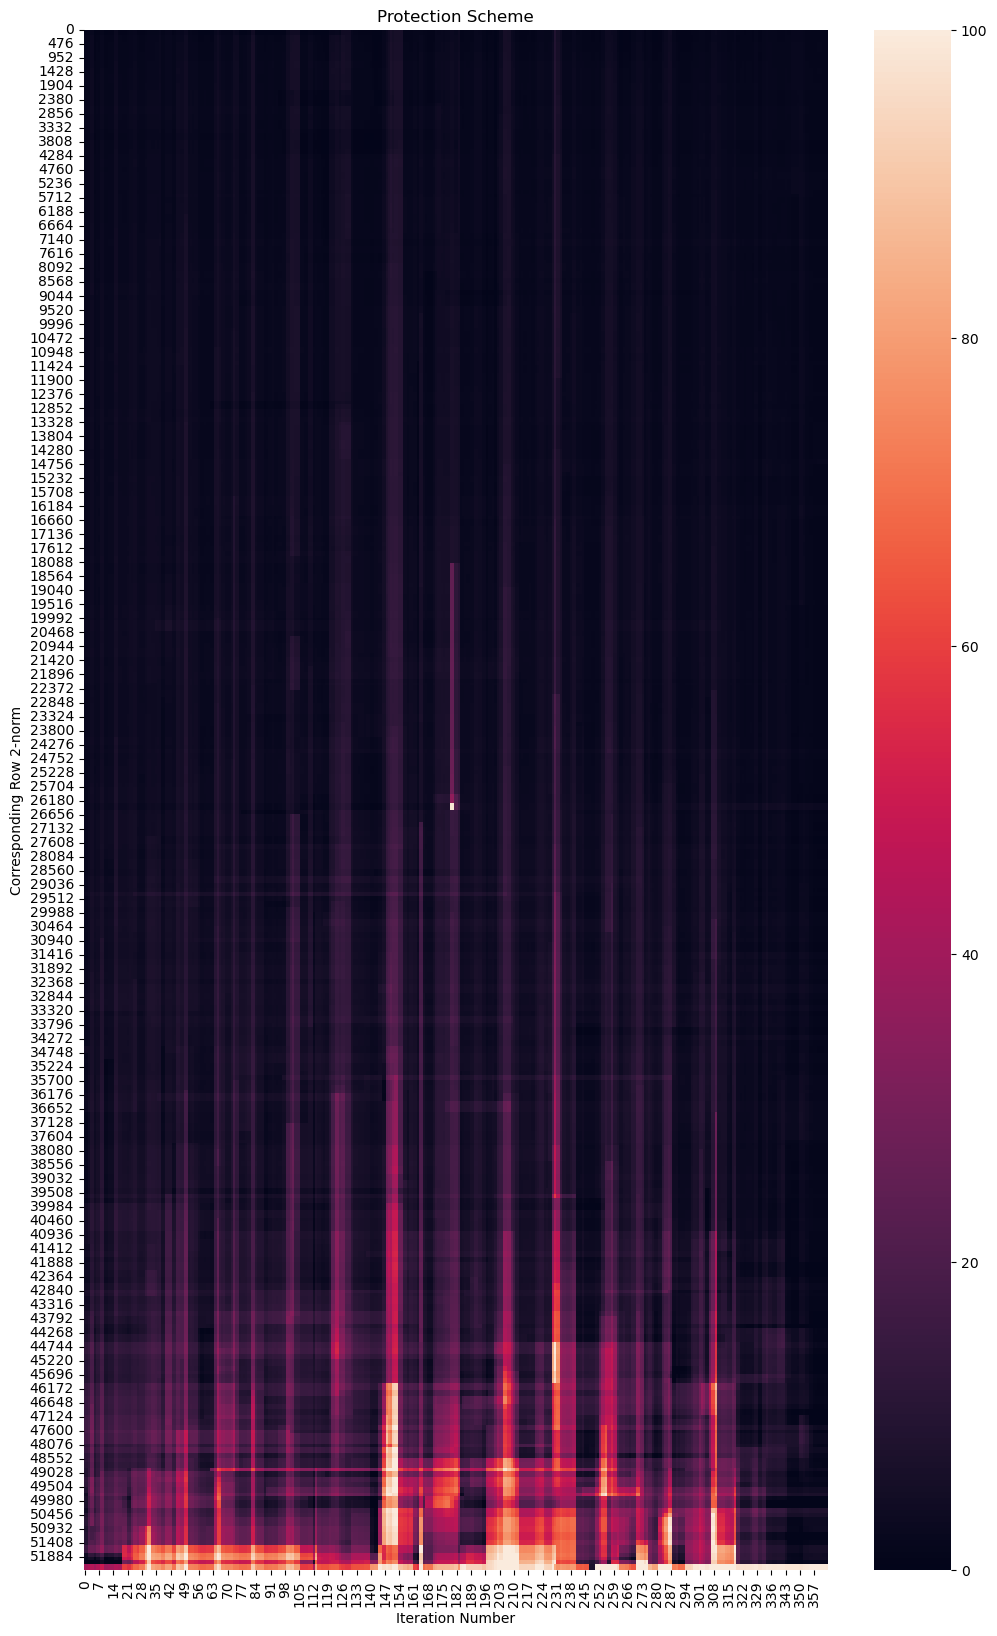

In [48]:
plt.gcf().set_size_inches(12, 20)
plt.gcf().set_dpi(100)
heatmap(protections, vmin=0, vmax=100)
plt.title("Protection Scheme")
plt.xlabel("Iteration Number")
plt.ylabel("Corresponding Row 2-norm")
plt.savefig(f"./figures/{matrix}/iter_r2n_output.png")
plt.show()

In [49]:
df_piv = df.pivot(index=["rowid"], columns="i", values="output")

protections = df_piv.to_numpy()
print(protections.shape, mat.shape, 11948 * 432)
df_piv.head()

(52329, 364) (52329, 52329) 5161536


i,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,354.0,355.0,356.0,357.0,358.0,359.0,360.0,361.0,362.0,363.0
rowid,,,,,,,,,,,,,,,,,,,,,
0.0,2.329354,2.329354,4.089900,6.824600,6.824600,3.278189,4.962789,4.989035,8.812190,8.812190,...,3.231157,2.070743,2.070743,1.870260,1.881471,1.855159,1.855159,1.848431,1.844543,1.835187
1.0,3.153547,3.153547,4.077080,7.308465,7.308465,4.853302,5.404436,5.353563,9.118546,9.118546,...,3.067486,1.737779,1.737779,1.345780,1.348054,1.331466,1.331466,1.325667,1.348720,1.349185
2.0,2.255072,2.255072,3.026002,6.213146,6.213146,3.727931,4.279066,4.228194,7.993176,7.993176,...,2.271130,0.988049,0.988049,0.656168,0.660844,0.646790,0.646790,0.641933,0.667580,0.661416
3.0,15.550994,15.550994,25.989891,27.281408,27.281408,26.322586,30.736454,30.790503,36.432789,36.432789,...,5.445369,5.902797,5.902797,5.965396,5.965396,5.954512,5.954512,6.041568,6.041568,5.632675
4.0,15.550994,15.550994,25.989891,27.281408,27.281408,26.322586,30.736454,30.790503,36.432789,36.432789,...,5.445369,5.902797,5.902797,5.965396,5.965396,5.954512,5.954512,6.041568,6.041568,5.632675


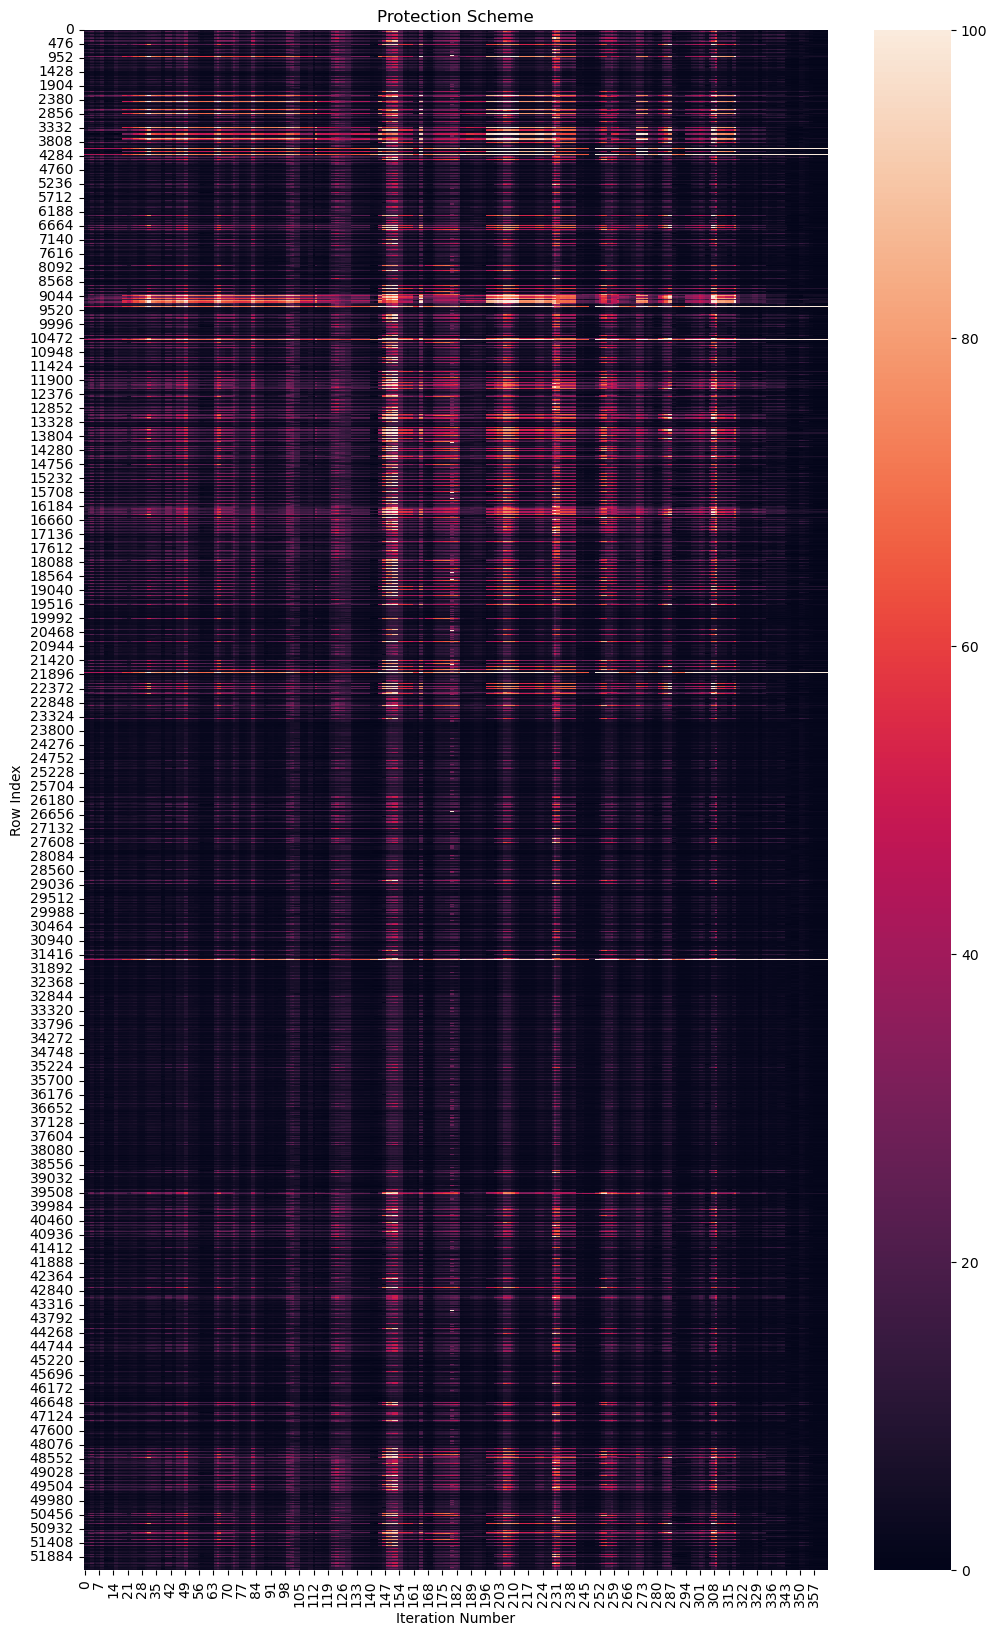

In [50]:
plt.gcf().set_size_inches(12, 20)
plt.gcf().set_dpi(100)
heatmap(protections, vmin=0, vmax=100)
plt.title("Protection Scheme")
plt.xlabel("Iteration Number")
plt.ylabel("Row Index")
plt.savefig(f"./figures/{matrix}/iter_row_output.png")
plt.show()